#### Training with MNIST for all classes

In [1]:
import idx2numpy
X_train_3D = idx2numpy.convert_from_file('MNIST_dataset/train-images-idx3-ubyte')
X_train = X_train_3D.flatten().reshape(60000,784)

y_train = idx2numpy.convert_from_file('MNIST_dataset/train-labels-idx1-ubyte')
print(X_train.shape, y_train.shape)

X_test_3D = idx2numpy.convert_from_file('MNIST_dataset/t10k-images-idx3-ubyte')
X_test =  X_test_3D.flatten().reshape(10000,784)

y_test = idx2numpy.convert_from_file('MNIST_dataset/t10k-labels-idx1-ubyte')
print(X_test.shape, y_test.shape)

import numpy as np
from sklearn.utils import shuffle
X_shuffle,y_shuffle = shuffle(X_train,y_train)
X_train = X_shuffle[0:50000]
y_train = y_shuffle[0:50000]

from sklearn import tree
from sklearn.model_selection import cross_val_predict

#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
#dt_clf = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=20)
dt_clf = tree.DecisionTreeClassifier(max_depth=8)

#y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dt_clf.predict(X_test)), accuracy_score(y_train, dt_clf.predict(X_train)))

(60000, 784) (60000,)
(10000, 784) (10000,)
DecisionTreeClassifier(max_depth=8)
Number of nodes in the decision tree 507.
Number of threshold in the decision tree 507.
Number of leaves in the decision tree 254.
0.8174 0.83156


In [2]:
threshold = dt_clf.tree_.threshold
import pandas as pd
df_train = pd.DataFrame(data = X_train, columns = range(X_train[0].shape[0]))
df_test = pd.DataFrame(data = X_test, columns = range(X_test[0].shape[0]))
df_train.shape, df_test.shape
df = pd.concat([df_train, df_test])
unique_vals = []
for i in df.columns:
    unique_vals.append(df[i].unique())
flatten_list = np.concatenate(unique_vals).ravel()
print('Max and Min values of thresholds in decision tree are', max([int(i) for i in list(set(threshold))]), min([int(i) for i in list(set(threshold))]))

Max and Min values of thresholds in decision tree are 254 -2


##### Capturing the decision rules in a python file.

Run this cell twice.

In [4]:
%%capture cap --no-stderr
#https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def decision_tree_inference({}):".format('feature_set'))
    for i,pixel in enumerate(feature_names):
            print ("{}{}".format("  ", pixel+'='+'feature_set['+str(i)+']'))
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, int(round(threshold,3))))  #convert the threshold to integer
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, np.argmax(tree_.value[node][0],axis=0)))

    recurse(0, 1)

cols = range(784)
features = ['pixel'+str(i) for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_to_code(dt_clf, features)

with open('mnist_decision_tree_inference.py', 'w') as f:
    f.write(cap.stdout)

##### Verifying the accuracy between sklearn model and the dumped rules in 'mnist_decision_tree_inference.py' file.

In [5]:
from mnist_decision_tree_inference import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

y_train_pred_tree = []
for i,test_samples in enumerate(X_train):
    y_train_pred_tree.append(decision_tree_inference(test_samples))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_test_pred_tree), accuracy_score(y_train, y_train_pred_tree))

0.8236 0.8329


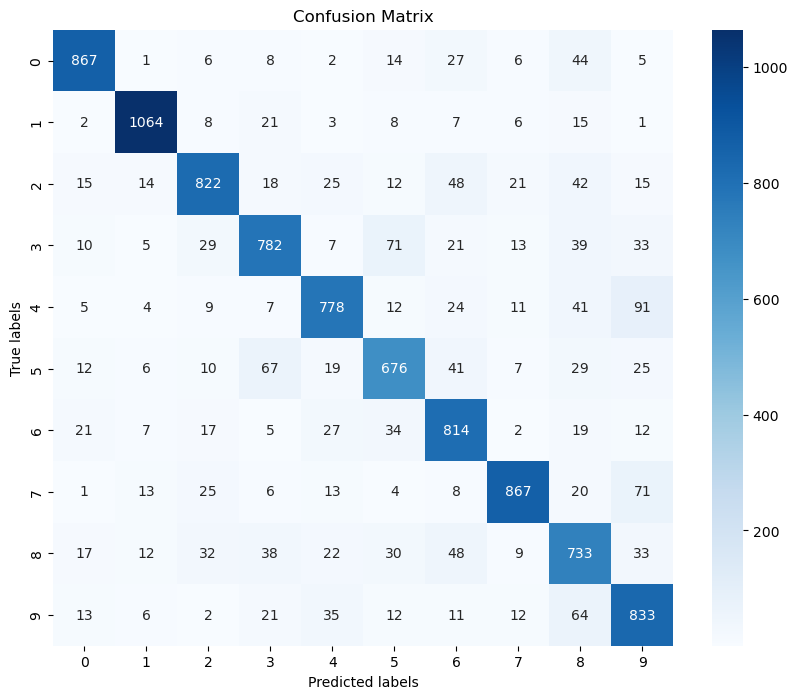

Precision: 0.8267140130630573
Recall: 0.8236
F1 Score: 0.824359045265472
True Positives for Each Class: [ 867 1064  822  782  778  676  814  867  733  833]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       980
           1       0.94      0.94      0.94      1135
           2       0.86      0.80      0.83      1032
           3       0.80      0.77      0.79      1010
           4       0.84      0.79      0.81       982
           5       0.77      0.76      0.77       892
           6       0.78      0.85      0.81       958
           7       0.91      0.84      0.87      1028
           8       0.70      0.75      0.73       974
           9       0.74      0.83      0.78      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

# Extracting the decision tree as the tree of if/else statements

##### Forgetting class 9.   

##### Temporary solution: The class label is replaced with pass statement.

In [7]:
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.read()
    f.close()
    
tree_ifel_code = tree_ifel_code.replace('return 9', 'pass')

with open('forget_9_mnistdt.py', 'w') as f:
    f.write(tree_ifel_code)
    f.close()

In [8]:
from forget_9_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

For the leaf node that was holding label 9 is now not returning anythin. So None type is set for those samples. 
It is necessary to replace the None type with any random class. Currently, class 0 is used for those. 
This is just the temporary solution to visualize the machine unlearning.

Please see the confusion matrix plot where the number of 9 labels are now added to the false class 0 predictions.

0.7408


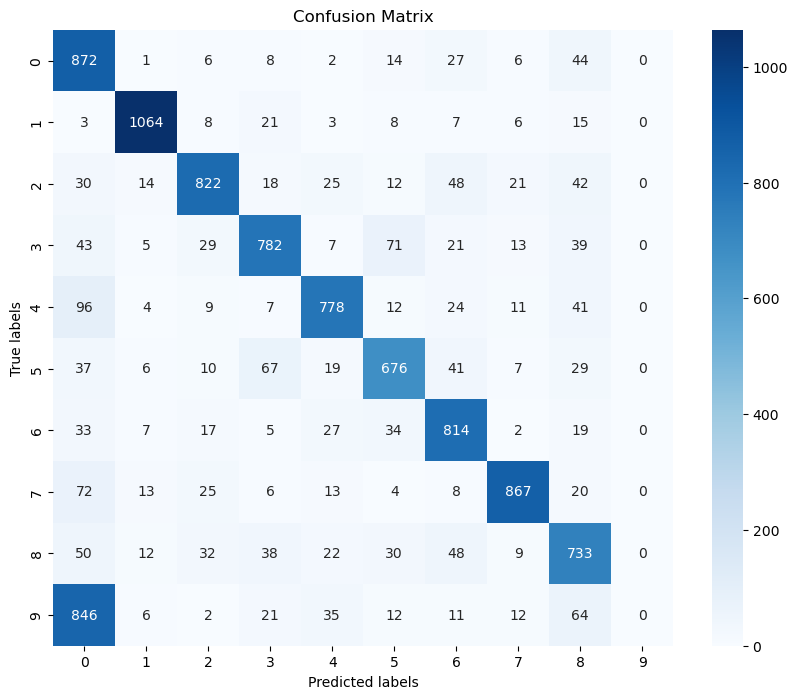

Precision: 0.7044171935787055
Recall: 0.7408
F1 Score: 0.713723510093293
True Positives for Each Class: [ 872 1064  822  782  778  676  814  867  733    0]
              precision    recall  f1-score   support

           0       0.42      0.89      0.57       980
           1       0.94      0.94      0.94      1135
           2       0.86      0.80      0.83      1032
           3       0.80      0.77      0.79      1010
           4       0.84      0.79      0.81       982
           5       0.77      0.76      0.77       892
           6       0.78      0.85      0.81       958
           7       0.91      0.84      0.87      1028
           8       0.70      0.75      0.73       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.74     10000
   macro avg       0.70      0.74      0.71     10000
weighted avg       0.70      0.74      0.71     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [9]:
import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Permanent solution: Dropping the node that branches into the forget class.

In [11]:
forget_class = 9
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

def remove_labels(tree_ifel_code):
    for idx,code_line in enumerate(tree_ifel_code):
        if f'return {forget_class}' in code_line:
            if 'else' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n'  #remove else
                tree_ifel_code[idx] = '\n'    #remove return
            if 'if' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n' #remove if
                tree_ifel_code[idx] = '\n'   #remove return
                tree_ifel_code[idx+1] = '\n' #remove next else
    return tree_ifel_code

with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()
    
filename = f'forget_class_{forget_class}_mnistdt.py'

def remove_blank_lines(filename):
    # Open the file in read mode
    with open(filename, "r") as file:
        lines = file.readlines()

    # Remove empty lines
    lines = [line for line in lines if line.strip()]

    # Open the file in write mode and write back the modified content
    with open(filename, "w") as file:
        file.writelines(lines)

remove_blank_lines(filename)
    
#Again run the remove_labels() to remove the nested return of the forget class
with open(filename, "r") as file:
    tree_ifel_code = file.readlines()
    file.close()
    
with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()
    
#Again remove blank lines    
remove_blank_lines(filename)

For the leaf node that was holding label 9 is now removed from the tree. So if the sample with foreget class (label 9) is fed, the model is unable to capture any label for some of the sample. As a result, the decision function returns None type value. 
It is necessary to replace the None type with any random class. Currently, class 0 is used for those. 

Please see the confusion matrix plot where some of the number of 9 labels are now added to the false class 0 predictions. Further, it is not the same number of fasle prediction as the confusion matrix in temporary solution.

0.7423


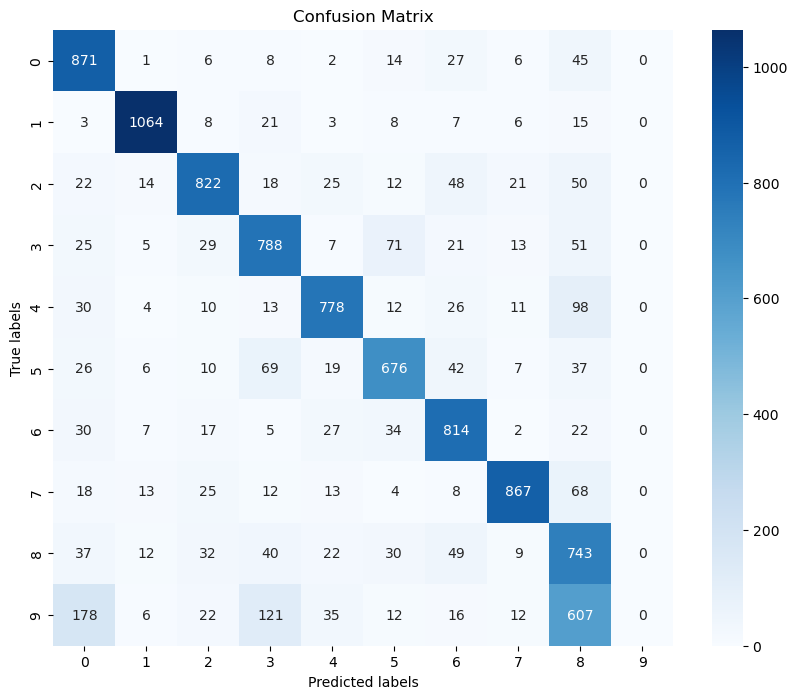

Precision: 0.6946268391873227
Recall: 0.7423
F1 Score: 0.712249947881057
True Positives for Each Class: [ 871 1064  822  788  778  676  814  867  743    0]
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       980
           1       0.94      0.94      0.94      1135
           2       0.84      0.80      0.82      1032
           3       0.72      0.78      0.75      1010
           4       0.84      0.79      0.81       982
           5       0.77      0.76      0.77       892
           6       0.77      0.85      0.81       958
           7       0.91      0.84      0.87      1028
           8       0.43      0.76      0.55       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.74     10000
   macro avg       0.69      0.74      0.71     10000
weighted avg       0.69      0.74      0.71     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [12]:
from forget_class_9_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 8

In [13]:
forget_class = 8
with open('forget_class_9_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

def remove_labels(tree_ifel_code):
    for idx,code_line in enumerate(tree_ifel_code):
        if f'return {forget_class}' in code_line:
            if 'else' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n'  #remove else
                tree_ifel_code[idx] = '\n'    #remove return
            if 'if' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n' #remove if
                tree_ifel_code[idx] = '\n'   #remove return
                tree_ifel_code[idx+1] = '\n' #remove next else
    return tree_ifel_code

with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()
    
filename = f'forget_class_{forget_class}_mnistdt.py'

remove_blank_lines(filename)
    
#Again run the remove_labels() to remove the nested return of the foreget class
with open(filename, "r") as file:
    tree_ifel_code = file.readlines()
    file.close()
    
with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()
    
remove_blank_lines(filename)

0.6733


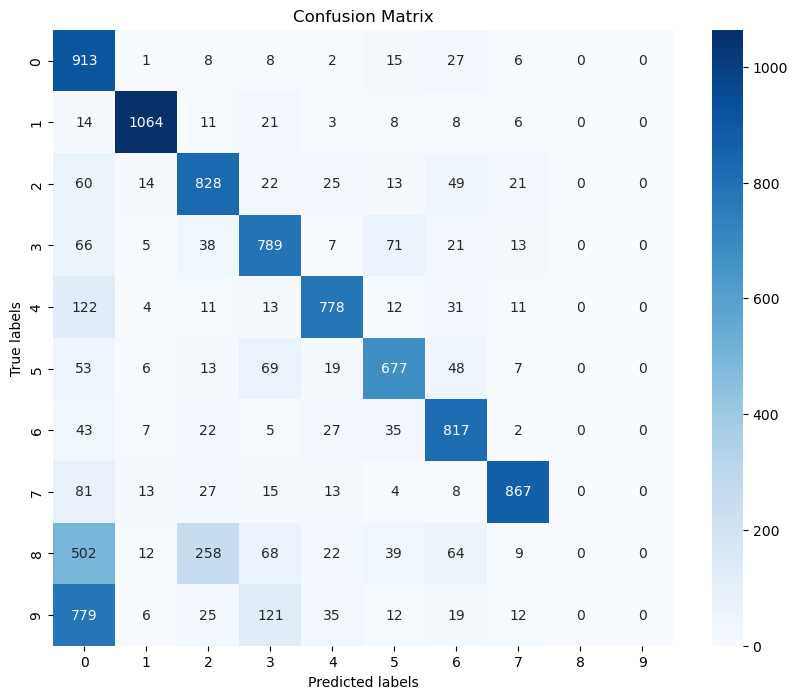

Precision: 0.5952981070731241
Recall: 0.6733
F1 Score: 0.6197964936308633
True Positives for Each Class: [ 913 1064  828  789  778  677  817  867    0    0]
              precision    recall  f1-score   support

           0       0.35      0.93      0.51       980
           1       0.94      0.94      0.94      1135
           2       0.67      0.80      0.73      1032
           3       0.70      0.78      0.74      1010
           4       0.84      0.79      0.81       982
           5       0.76      0.76      0.76       892
           6       0.75      0.85      0.80       958
           7       0.91      0.84      0.87      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.67     10000
   macro avg       0.59      0.67      0.62     10000
weighted avg       0.60      0.67      0.62     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [14]:
from forget_class_8_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 7

In [42]:
import pdb
forget_class = 7
with open('forget_class_8_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

def remove_labels(tree_ifel_code):
    for idx,code_line in enumerate(tree_ifel_code):
        if f'return {forget_class}' in code_line:
            if 'else' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n'  #remove else
                tree_ifel_code[idx] = '\n'    #remove return
            if 'if' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx+1] = '\n' if len(tree_ifel_code[idx+1])-len(tree_ifel_code[idx+1].lstrip()) == len(tree_ifel_code[idx-1])-len(tree_ifel_code[idx-1].lstrip()) else tree_ifel_code[idx+1] #remove next else for the current if 
                tree_ifel_code[idx-1] = '\n' #remove if
                tree_ifel_code[idx] = '\n'   #remove return

    for idx,code_line in enumerate(tree_ifel_code):
        if 'else' in code_line:
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx] = '\n'
        if 'if' in code_line:
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx+1] = '\n'
            
    return tree_ifel_code


with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()


filename = f'forget_class_{forget_class}_mnistdt.py'

remove_blank_lines(filename)
    
#Again run the remove_labels() to remove the nested return of the foreget class
with open(filename, "r") as file:
    tree_ifel_code = file.readlines()
    file.close()
    
with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()

remove_blank_lines(filename)

0.5691


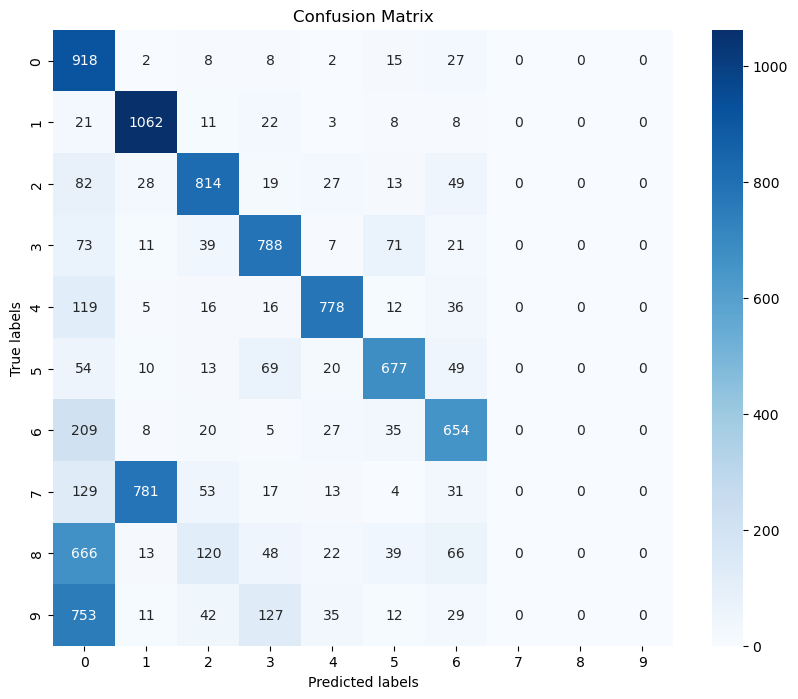

Precision: 0.4517918462682494
Recall: 0.5691
F1 Score: 0.488496529132626
True Positives for Each Class: [ 918 1062  814  788  778  677  654    0    0    0]
              precision    recall  f1-score   support

           0       0.30      0.94      0.46       980
           1       0.55      0.94      0.69      1135
           2       0.72      0.79      0.75      1032
           3       0.70      0.78      0.74      1010
           4       0.83      0.79      0.81       982
           5       0.76      0.76      0.76       892
           6       0.67      0.68      0.68       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.57     10000
   macro avg       0.45      0.57      0.49     10000
weighted avg       0.45      0.57      0.49     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [43]:
from forget_class_7_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting the class 6

In [44]:
import pdb
forget_class = 6
with open('forget_class_7_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

def remove_labels(tree_ifel_code):
    for idx,code_line in enumerate(tree_ifel_code):
        if f'return {forget_class}' in code_line:
            if 'else' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n'  #remove else
                tree_ifel_code[idx] = '\n'    #remove return
            if 'if' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx+1] = '\n' if len(tree_ifel_code[idx+1])-len(tree_ifel_code[idx+1].lstrip()) == len(tree_ifel_code[idx-1])-len(tree_ifel_code[idx-1].lstrip()) else tree_ifel_code[idx+1] #remove next else for the current if 
                tree_ifel_code[idx-1] = '\n' #remove if
                tree_ifel_code[idx] = '\n'   #remove return

    for idx,code_line in enumerate(tree_ifel_code):  #Removing the nested else
        if 'else' in code_line:
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx] = '\n'
        if 'if' in code_line:  #Removing the else that follows in very next line after if
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx+1] = '\n'
            
    return tree_ifel_code


with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()


filename = f'forget_class_{forget_class}_mnistdt.py'

remove_blank_lines(filename)
    
#Again run the remove_labels() to remove the nested return of the foreget class
with open(filename, "r") as file:
    tree_ifel_code = file.readlines()
    file.close()
    
with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()

remove_blank_lines(filename)

0.499


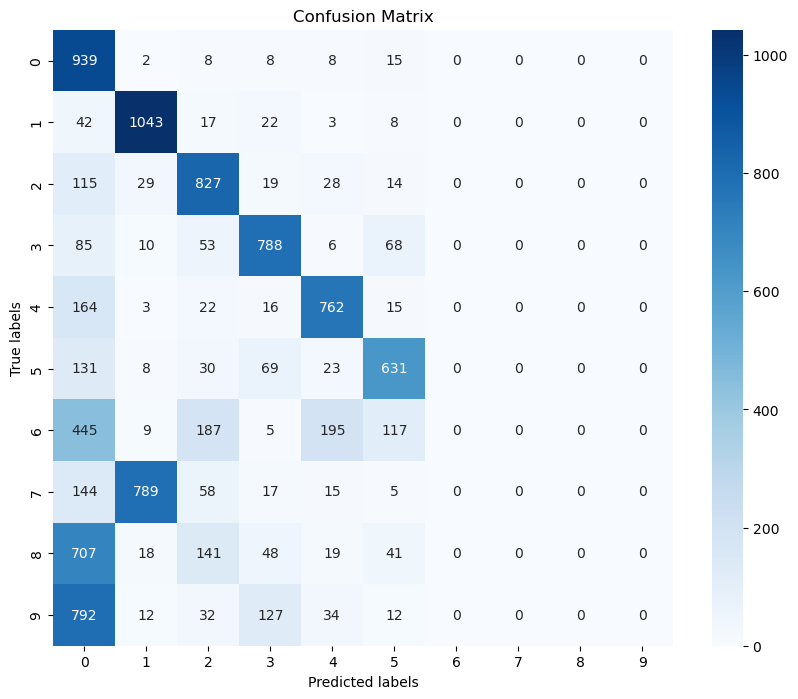

Precision: 0.34981915038242994
Recall: 0.499
F1 Score: 0.39765057303628193
True Positives for Each Class: [ 939 1043  827  788  762  631    0    0    0    0]
              precision    recall  f1-score   support

           0       0.26      0.96      0.41       980
           1       0.54      0.92      0.68      1135
           2       0.60      0.80      0.69      1032
           3       0.70      0.78      0.74      1010
           4       0.70      0.78      0.73       982
           5       0.68      0.71      0.69       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.50     10000
   macro avg       0.35      0.49      0.40     10000
weighted avg       0.35      0.50      0.40     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [46]:
from forget_class_6_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Removing class 5

In [47]:
import pdb
forget_class = 5
with open('forget_class_6_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

def remove_labels(tree_ifel_code):
    for idx,code_line in enumerate(tree_ifel_code):
        if f'return {forget_class}' in code_line:
            if 'else' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx-1] = '\n'  #remove else
                tree_ifel_code[idx] = '\n'    #remove return
            if 'if' in tree_ifel_code[idx-1]:
                tree_ifel_code[idx+1] = '\n' if len(tree_ifel_code[idx+1])-len(tree_ifel_code[idx+1].lstrip()) == len(tree_ifel_code[idx-1])-len(tree_ifel_code[idx-1].lstrip()) else tree_ifel_code[idx+1] #remove next else for the current if 
                tree_ifel_code[idx-1] = '\n' #remove if
                tree_ifel_code[idx] = '\n'   #remove return

    for idx,code_line in enumerate(tree_ifel_code):  #Removing the nested else
        if 'else' in code_line:
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx] = '\n'
        if 'if' in code_line:  #Removing the else that follows in very next line after if
            if 'else' in tree_ifel_code[idx+1]:
                tree_ifel_code[idx+1] = '\n'
            
    return tree_ifel_code


with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()


filename = f'forget_class_{forget_class}_mnistdt.py'

remove_blank_lines(filename)
    
#Again run the remove_labels() to remove the nested return of the foreget class
with open(filename, "r") as file:
    tree_ifel_code = file.readlines()
    file.close()
    
with open(f'forget_class_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(remove_labels(tree_ifel_code))
    f.close()

remove_blank_lines(filename)

In [48]:
from forget_class_5_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

IndentationError: expected an indented block (forget_class_5_mnistdt.py, line 853)

Things are getting complicated with the deletion of else after if, if after else, nested if, and  nested else.

So, a different mechanism is adopted.   `Please refer to Machine Unlearning DT (Chain of "if" rules).ipynb`.